StockBot Prediction Algorithm (RNN-LSTM)

In [1]:
import os

#plotting + constructing dataframes imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#model architecture imports
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

#whyyyyyyyy - minmaxscaler technically wouldn't work bc vals that shouldn't be normalized are being normalized
#-> not reflective of the << potential >> price the stock could reach.
#also, lol code needs major refactoring -> more abstractions for RNN and window construction
#question, using the same tools, other than changing the LSTM/Dense/Dropout funcs, how can we write this
#differently?

#retrain it with 'aaww.us.txt' bc it's better?

In [2]:
df = pd.read_csv('aaww.us.txt')
print(df)

            Date   Open    High      Low  Close  Volume  OpenInt
0     2005-02-25  29.50  29.500  29.5000  29.50   12600        0
1     2005-02-28  30.00  30.000  29.2500  29.53  400200        0
2     2005-03-01  29.25  29.250  28.7500  29.00  371661        0
3     2005-03-02  29.00  29.250  29.0000  29.25   38600        0
4     2005-03-04  29.25  29.250  29.2500  29.25     200        0
...          ...    ...     ...      ...    ...     ...      ...
3157  2017-11-06  60.50  61.250  58.9505  60.85  297111        0
3158  2017-11-07  56.05  57.850  55.6500  56.05  984360        0
3159  2017-11-08  58.50  59.650  57.1000  57.25  416385        0
3160  2017-11-09  56.60  56.850  54.6000  54.75  465227        0
3161  2017-11-10  54.55  54.625  52.6000  53.85  561466        0

[3162 rows x 7 columns]


In [3]:
#focus on forecasting the first column - 'Open'
df = df['Open'].values
print(df.shape)

(3162,)


In [4]:
df = df.reshape(-1,1) #vector transformation to obtain a two dimensional array -> fit for further analysis
print(df.shape)
print(df)

(3162, 1)
[[29.5 ]
 [30.  ]
 [29.25]
 ...
 [58.5 ]
 [56.6 ]
 [54.55]]


In [5]:
train_set = np.array(df[:int(df.shape[0]*0.8)])
test_set = np.array(df[int(df.shape[0]*0.8)-50:])
print(train_set.shape)
print(test_set.shape)

(2529, 1)
(683, 1)


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
train_set = scaler.fit_transform(train_set)
train_set[:5]

array([[0.32634296],
       [0.33440878],
       [0.32231005],
       [0.31827714],
       [0.32231005]])

In [7]:
#scaler = MinMaxScaler(feature_range=(0,1))
test_set = scaler.transform(test_set)
test_set[:5]

array([[0.57896435],
       [0.57718987],
       [0.60880787],
       [0.59703178],
       [0.59477335]])

In [8]:
df.shape[0]

3162

In [9]:
# this function takes the dataframe parameter and ... whyyy 50?? - to build a buffer?? # the way the windows are being created is crazy good
def create_dataset(df):
  X = []
  y = []
  for i in range(50, df.shape[0]):
    X.append(df[i-50:i,0])
    y.append(df[i,0])
  X = np.array(X)
  y = np.array(y)
  return X,y

In [10]:
x_train, y_train = create_dataset(train_set)
x_train[:1]

array([[0.32634296, 0.33440878, 0.32231005, 0.31827714, 0.32231005,
        0.32634296, 0.32150347, 0.31424423, 0.31424423, 0.31827714,
        0.31424423, 0.31827714, 0.31440555, 0.30053234, 0.29730602,
        0.2981126 , 0.29004678, 0.28601387, 0.28198096, 0.28601387,
        0.29004678, 0.28198096, 0.27794806, 0.26181642, 0.24568479,
        0.23600581, 0.23761897, 0.24165188, 0.26100984, 0.23761897,
        0.2537506 , 0.26181642, 0.27794806, 0.28601387, 0.29407969,
        0.29891918, 0.31021132, 0.3158574 , 0.30214551, 0.33440878,
        0.33440878, 0.3465075 , 0.39893531, 0.38312631, 0.36667204,
        0.37473786, 0.38280368, 0.3908695 , 0.38683659, 0.39893531]])

In [11]:
x_test, y_test = create_dataset(test_set)
x_test[:1]

array([[0.57896435, 0.57718987, 0.60880787, 0.59703178, 0.59477335,
        0.59283755, 0.59445072, 0.57638329, 0.58331989, 0.59751573,
        0.60751734, 0.59880626, 0.59574125, 0.60864656, 0.61090498,
        0.61284078, 0.60929182, 0.61171157, 0.59799968, 0.57283433,
        0.57089853, 0.56622036, 0.53992579, 0.5518632 , 0.54137764,
        0.53879658, 0.53266656, 0.54524923, 0.54718503, 0.5547669 ,
        0.57331828, 0.57267301, 0.5686401 , 0.56234877, 0.55396032,
        0.56121955, 0.55686401, 0.54008711, 0.54702371, 0.54524923,
        0.53315051, 0.54992741, 0.61784159, 0.63897403, 0.69382158,
        0.72108405, 0.74657203, 0.75060494, 0.77641555, 0.76415551]])

In [12]:
# Reshaping feature for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Model

In [13]:
#initialize bot_regressor
bot_regressor = Sequential() 

#input + hidden layers
bot_regressor.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
bot_regressor.add(Dropout(0.2))

bot_regressor.add(LSTM(units=96, return_sequences=True))
bot_regressor.add(Dropout(0.2))

bot_regressor.add(LSTM(units=96, return_sequences=True))
bot_regressor.add(Dropout(0.2))

bot_regressor.add(LSTM(units=96))
bot_regressor.add(Dropout(0.2))

#output layer
bot_regressor.add(Dense(units=1))

# tweak units (existing val = 96. change it to 50 for instance, and see what happens to loss and accuracy)
# also change the number of LSTM layers and dropouts

In [14]:
# used root_mean_squared
bot_regressor.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
if(not os.path.exists('forecast.h5')):
    bot_regressor.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32) # when we actually train this, we'll set epochs to 100, and verbose=1 was added to the args
    bot_regressor.save('forecast.h5')

# print accuracy and confusion matrix to validate the model...

# take 2: 10 -> 30 epochs

Epoch 1/50
78/78 [==============================] - 17s 114ms/step - loss: 0.0194
Epoch 2/50
78/78 [==============================] - 9s 116ms/step - loss: 0.0056
Epoch 3/50
78/78 [==============================] - 9s 116ms/step - loss: 0.0060
Epoch 4/50
78/78 [==============================] - 9s 114ms/step - loss: 0.0051
Epoch 5/50
78/78 [==============================] - 9s 113ms/step - loss: 0.0041
Epoch 6/50
78/78 [==============================] - 9s 113ms/step - loss: 0.0035
Epoch 7/50
78/78 [==============================] - 9s 113ms/step - loss: 0.0037
Epoch 8/50
78/78 [==============================] - 9s 114ms/step - loss: 0.0034
Epoch 9/50
78/78 [==============================] - 9s 113ms/step - loss: 0.0033
Epoch 10/50
78/78 [==============================] - 9s 117ms/step - loss: 0.0032
Epoch 11/50
78/78 [==============================] - 10s 126ms/step - loss: 0.0031
Epoch 12/50
78/78 [==============================] - 9s 112ms/step - loss: 0.0027
Epoch 13/50
78/78 [====

In [16]:
model = load_model('forecast.h5')

Visualizing Predictions

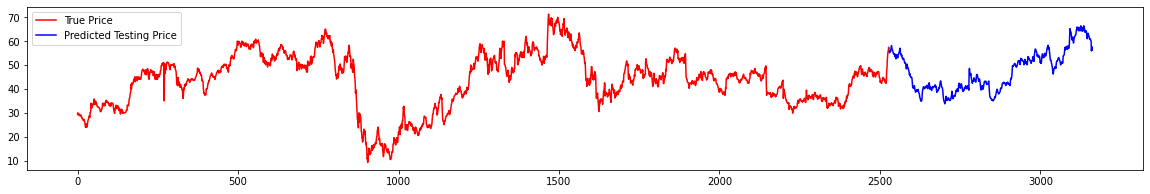

In [17]:
predictions = bot_regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# I know what to do to test this nowwwwww ---> fetch stock data for abco (window of 50)
# process the data the way we did for training / testing sets
# and use the create_dataset() function to feed that data into bot_regressor.predict()
# store that in a new 'predictions' variable and plot the outcomes like we do for the test! -- and the important thing to note here
# is that the way I pieced the two graphs together should be the most important change to the existing tutorial code
# what I do below is what needs to be done to predict the 'Open' of abco for tomorrow:::

#my code
fig, ax = plt.subplots(figsize=(20,3))
plt.plot(df[:len(y_train)+50], color='red',  label="True Price") # modified to show model forecasting what's gonna happen.
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [18]:
print(len(x_test[0]))

50


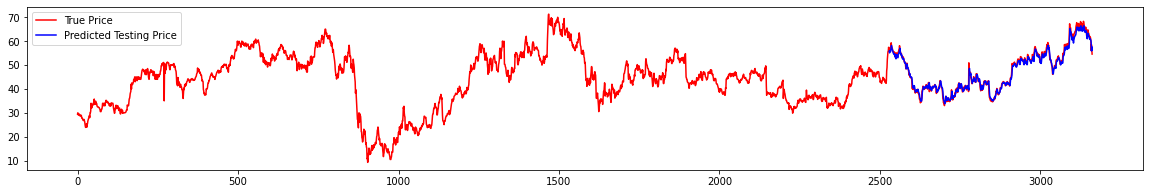

In [19]:
predictions = bot_regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(20,3))
plt.plot(df, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

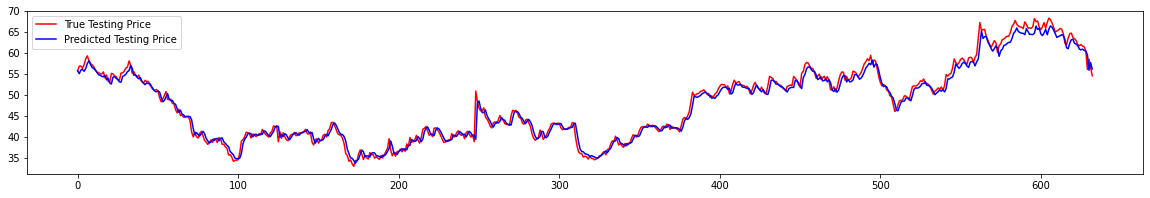

In [20]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(20,3))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

# the forecast needs to shift -20 units

In [21]:
print(len(predictions))

633


In [22]:
print(predictions[0])

[55.711605]


TODO - finish the confusion matrix for this model

my notes:

Next steps:
A large majority of this model was code reused from a LSTM tutorial.
In our case, we will need to do the same for Close, High, Low, and Volume.

The bigger question is what we want to predict moving forward. Predicting price is technically useless. Predicting returns will offer business value. 
Why? Reasons explained in another video (I'll discuss later.)

But for now, we have a model that's not dumb and hopefully not memorizing the dataset. LOLL

To replicate this process, we need to construct a class called RNN with attributes like dataset and methods like create_dataframe, create_matrices, split_data, fit_model_to_data, and feed_prediction. Create an instance of that class for each time series task (Open, Close, High, Low, Volume).

--
Input would be the day -> outputs would be (Open, Close, High, Low, Volume)...

why did aapl not work -> the model did not fit aapl's data because its trajectory was inaccurately normalized (we have to understand that there will be exceptions -> if we are using minmaxscaler, we can't normalize a stock that starts as a few cents and grows to hundreds of dollars. when we normalized the Opens, the values were very very small for the first couple price points compared to the latter portion of the dataset.

if we target predicting returns instead of prices, we don't need to deal with this problem.

tweak the window function to predict the next day based on a 7 day window, not 50 day windows

ATTEMPTING TO REQUEST / TEST ON ACTUAL DATA!!

In [23]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAWW&outputsize=compact&apikey=3BR7HYUPN64UVULS'
r = requests.get(url)
data = r.json()

#print(data)
# my API keyyy: 3BR7HYUPN64UVULS


time_series_retrieval = data['Time Series (Daily)']#['2022-03-23']

#print(time_series_retrieval)

#should I make a dictionary of every date in the year and set it equal to its day equivalent -- then encode and decode?
fetched_data = []
#print("start of fetching 'open' for AAWW (Atlas Air Worldwide Holdings) - fetch 100 prices")
for i in time_series_retrieval:
  fetched_data.append([float(time_series_retrieval[i]['1. open'])])
  #print(time_series_retrieval[i]['1. open'])
#print("end of fetching 'open' for AAWW (Atlas Air Worldwide Holdings)")
print(fetched_data)

[[85.92], [86.15], [88.17], [85.14], [83.3], [84.96], [81.52], [81.26], [82.74], [81.495], [81.78], [79.48], [81.59], [80.38], [80.98], [80.5], [78.3], [76.49], [75.01], [73.78], [74.88], [77.28], [77.23], [82.43], [78.24], [77.23], [76.2], [78.78], [79.66], [79.58], [78.36], [77.755], [79.88], [80.49], [81.67], [80.99], [75.76], [75.86], [78.22], [79.24], [78.29], [76.93], [77.27], [79.04], [81.75], [81.165], [85.14], [86.21], [87.5], [87.28], [87.7], [88.81], [90.8946], [95.76], [96.24], [94.79], [92.94], [93.0], [92.93], [92.9], [92.57], [91.97], [89.14], [89.11], [88.905], [87.87], [88.65], [87.5], [85.195], [86.6], [87.0], [86.61], [88.59], [88.11], [87.65], [86.84], [85.92], [89.15], [89.63], [93.62], [91.0], [94.52], [93.01], [90.0], [89.46], [88.91], [87.83], [87.54], [86.06], [85.24], [84.15], [83.66], [86.0], [86.11], [90.69], [89.33], [88.175], [83.63], [81.42], [80.47]]


In [61]:
'''
JUST FOR REFERENCE
def create_dataset(df):
  X = []
  y = []
  for i in range(50, df.shape[0]):
    X.append(df[i-50:i,0])
    y.append(df[i,0])
  X = np.array(X)
  y = np.array(y)
  return X,y
'''

'\nJUST FOR REFERENCE\ndef create_dataset(df):\n  X = []\n  y = []\n  for i in range(50, df.shape[0]):\n    X.append(df[i-50:i,0])\n    y.append(df[i,0])\n  X = np.array(X)\n  y = np.array(y)\n  return X,y\n'

In [24]:
#TODO: construct a valid dataframe -> inside the loop above, instead of just printing, print and hold on to the next couple data vals by storing
# them in an array and running that array of values through the create_dataset function below.

In [ ]:
#print(fetched_data)
fetched_data_dataframe = pd.DataFrame(fetched_data)
#print(fetched_data_dataframe)
x_validate, y_validate = create_dataset(fetched_data_dataframe.values) # AHHHHHHHHHHHHHHHHHH
x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1], 1))

#print('x_validate')
#print(x_validate)
#print('x_validate[0]')
#print(x_validate[0])

val_scaler = MinMaxScaler(feature_range=(0,1))
x_validate = val_scaler.fit_transform(x_validate[0])
print(x_validate)

In [33]:
validate_predictions = bot_regressor.predict(x_validate)
validate_predictions = val_scaler.inverse_transform(validate_predictions)
print(validate_predictions[0])

[83.158264]


don't know if this is the first or last one... lol

More Visualization

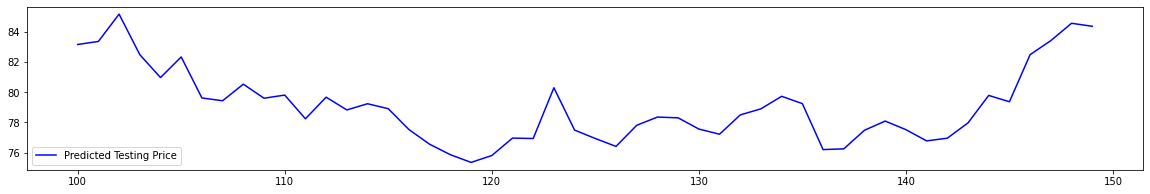

In [49]:
an_fig, an_ax = plt.subplots(figsize=(20,3))
an_ax.plot(range(len(y_validate)+50,len(y_validate)+50+len(validate_predictions)),validate_predictions, color='blue', label='Predicted Testing Price')
plt.legend()